In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

## tube network

In [2]:
path=os.getcwd()
path

os.chdir(path+'/underground/')

g_shp=nx.read_shp('underground.shp',geom_attrs=False)

df = nx.to_pandas_edgelist(g_shp)

# add station name to node
nod_st1={(e1):weight for e1, e2, weight in g_shp.edges(data='station_1_')}
nod_st2={(e2):weight for e1, e2, weight in g_shp.edges(data='station_2_')}

nod_all = nod_st1.copy()
nod_all.update(nod_st2)

nx.set_node_attributes(g_shp,nod_all,'station')

# convert to undirected
g_shp_un = g_shp.to_undirected()

# ID assignment
nod_coord = {(e1):e1 for e1 in g_shp_un.nodes()}
nx.set_node_attributes(g_shp_un,nod_coord,'station_coord')

node_list = list(g_shp_un.nodes())
mapping = {node_list[i]:i for i in range(len(node_list))}
g_shp_un = nx.relabel_nodes(g_shp_un, mapping)

nodes = [(x,y) for x,y in g_shp_un.nodes(data='station') if 'Heathrow' in str(y)]

g_shp_un.nodes[258]['station']='Heathrow Terminals 123'

## flow

In [3]:
os.chdir('/Users/zhangjiawei/week1/TubeCommuters_Practical')
orig_dest = pd.read_csv('ODtube2017.csv')

In [4]:
g_OD = nx.from_pandas_edgelist(orig_dest, 'station_name', 'station_name.1',['total_wtrips'],create_using=nx.MultiDiGraph)

list(g_OD.edges(data=True))[0:10]

[('Acton Town', 'Alperton', {'total_wtrips': 143}),
 ('Acton Town', 'Amersham', {'total_wtrips': 22}),
 ('Acton Town', 'Angel', {'total_wtrips': 15}),
 ('Acton Town', 'Archway', {'total_wtrips': 9}),
 ('Acton Town', 'Arsenal', {'total_wtrips': 9}),
 ('Acton Town', 'Baker Street', {'total_wtrips': 19}),
 ('Acton Town', 'Bank', {'total_wtrips': 226}),
 ('Acton Town', 'Barbican', {'total_wtrips': 7}),
 ('Acton Town', 'Barons Court', {'total_wtrips': 36}),
 ('Acton Town', 'Bayswater', {'total_wtrips': 2})]

In [5]:
nod_names={(e1):e1 for e1 in g_OD.nodes()}
nx.set_node_attributes(g_OD,nod_names,'station')

mapping = {g_shp_un.nodes[i]['station']:i for i in g_shp_un.nodes()} 
g_OD = nx.relabel_nodes(g_OD, mapping)

nod_coords={(e1):coord for e1, coord in g_shp_un.nodes(data='station_coord')} #e1 is id, coord is coordination
nx.set_node_attributes(g_OD,nod_coords,'station_coord')

pos = {e1: xy for e1,xy in g_OD.nodes(data='station_coord')}
list(g_OD.nodes(data=True))[0:10]

[(111, {'station': 'Acton Town', 'station_coord': (-0.2801, 51.5028)}),
 (238, {'station': 'Alperton', 'station_coord': (-0.2997, 51.5407)}),
 (172, {'station': 'Amersham', 'station_coord': (-0.607, 51.6736)}),
 (196, {'station': 'Angel', 'station_coord': (-0.1058, 51.5322)}),
 (198, {'station': 'Archway', 'station_coord': (-0.1353, 51.5653)}),
 (244, {'station': 'Arsenal', 'station_coord': (-0.1059, 51.5586)}),
 (0, {'station': 'Baker Street', 'station_coord': (-0.1571, 51.5226)}),
 (25, {'station': 'Bank', 'station_coord': (-0.0886, 51.5133)}),
 (77, {'station': 'Barbican', 'station_coord': (-0.0979, 51.5204)}),
 (100, {'station': 'Barons Court', 'station_coord': (-0.2139, 51.4905)})]

In [6]:
N=len(g_shp_un.nodes()) 
adj_c=np.zeros((N, N))

for e1,e2,C in g_OD.edges(data='total_wtrips'):
    path = nx.dijkstra_path(g_shp_un,e1,e2)  #undirected network path only for flow
    path_edges = list(zip(path,path[1:]))   #edge along the path
    for (s1,s2) in path_edges:
            adj_c[s1,s2]=adj_c[s1,s2]+C    #only those nodes that are connected have values
            
        

adj_c

array([[    0., 15400., 36470., ...,     0.,     0.,     0.],
       [15035.,     0.,     0., ...,     0.,     0.,     0.],
       [19675.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [7]:
df_before = pd.DataFrame(adj_c)
sum_of_flows_before=df_before.values.sum()
df_before

,0,1,2,3,4,5,6,7,8,9,...,296,297,298,299,300,301,302,303,304,305
0,0.0,15400.0,36470.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15035.0,0.0,0.0,0.0,0.0,0.0,5231.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19675.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,17550.0,24199.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,31528.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Create the new graph from the adjancency matrix:
g_flows=nx.from_numpy_matrix(adj_c, create_using=nx.DiGraph) 

#list(g_flows.edges(data=True))[0:1]

nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(g_flows,nod_coord,'station_coord')

nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(g_flows,nod_names,'station')

#list(g_flows.nodes(data=True))[0]

#as edges are saved using the IDs, let us create an edges attribute with the station names:
edges_names={(e1,e2):(g_flows.nodes[e1]['station'],g_flows.nodes[e2]['station']) for e1,e2 in g_flows.edges()}

nx.set_edge_attributes(g_flows,edges_names,'station_names')
list(g_flows.edges(data=True))[0:1]

[(0, 1, {'weight': 15400.0, 'station_names': ('Baker Street', 'Marylebone')})]

### Use the result from the part1

In [32]:
g_shp_un_sequential=g_shp_un.copy()

from collections import OrderedDict

i=0

while i<10:
    bet_london_w=nx.betweenness_centrality(g_shp_un_sequential, weight='distance', normalized=False)
    nx.set_node_attributes(g_shp_un_sequential,bet_london_w,'betweenness_un')
    dict_bet_un=dict(g_shp_un_sequential.nodes(data=True))
    listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True))
    #print(list(listbet_un.items())[0])
    g_shp_un_sequential.remove_node(list(listbet_un.items())[0][0])
    i+=1
  

In [33]:
# use the fragmented network to build adj  
N=len(g_shp_un.nodes()) 
adj_c_after=np.zeros((N, N))

for e1,e2,C in g_OD.edges(data='total_wtrips'):
    try:
        path = nx.dijkstra_path(g_shp_un_sequential,e1,e2)  #undirected network path only for flow
        path_edges = list(zip(path,path[1:])) 
        for (s1,s2) in path_edges:
            adj_c_after[s1,s2]=adj_c_after[s1,s2]+C 
    except:
        continue    #only those nodes that are connected have values
            
        

adj_c_after

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0., 1445.,    0.],
       [   0.,    0.,    0., ..., 2369.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [34]:
df_after = pd.DataFrame(adj_c_after)
sum_of_flows_after=df_after.values.sum()
sum_of_flows_after

2931297.0

In [35]:
difference=adj_c-adj_c_after
#df_impact = pd.DataFrame(q)
#a=sum_of_flows_before-sum_of_flows_after
#a

### plot the difference

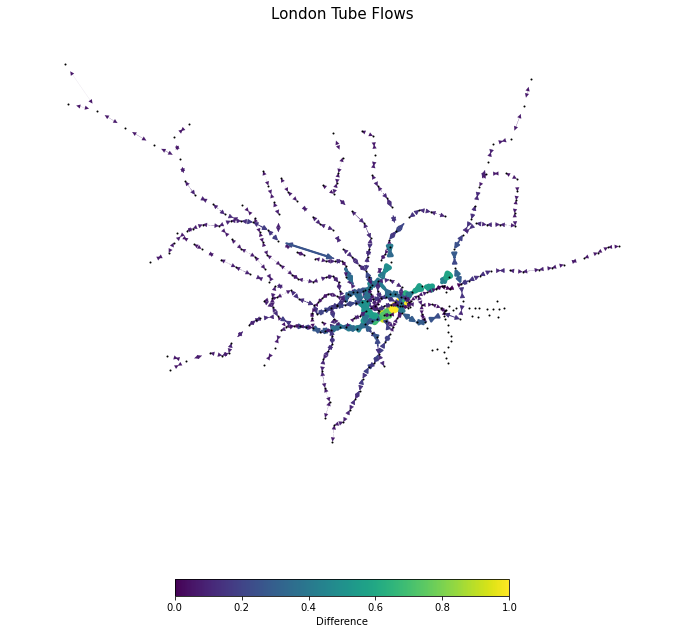

In [36]:
#Create the new graph from the adjancency matrix:
G=nx.from_numpy_matrix(difference, create_using=nx.DiGraph) 

#list(g_flows.edges(data=True))[0:1]

nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(G,nod_coord,'station_coord')

nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(G,nod_names,'station')

#list(g_flows.nodes(data=True))[0]

#as edges are saved using the IDs, let us create an edges attribute with the station names:
edges_names={(e1,e2):(G.nodes[e1]['station'],G.nodes[e2]['station']) for e1,e2 in G.edges()}

nx.set_edge_attributes(G,edges_names,'station_names')
#list(G.edges(data=True))[0:1]

## plot !!

# Lets set colour and size of nodes according to the flows_
weights = [w for e1,e2,w in G.edges(data='weight')]

weights_color=[(w/max(weights)) for e1,e2,w in G.edges(data='weight')]
weights_size=[(w/max(weights)*10) for e1,e2,w in G.edges(data='weight')]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in G.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(G, pos,edge_color=weights_color, width=weights_size)
#edg=nx.draw_networkx_edges(G, pos, width=weights_size)


nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(nod,label="Difference",orientation="horizontal", shrink=0.5)

plt.axis("off")
plt.title("London Tube Flows",fontsize=15)
plt.show()

### plot the before

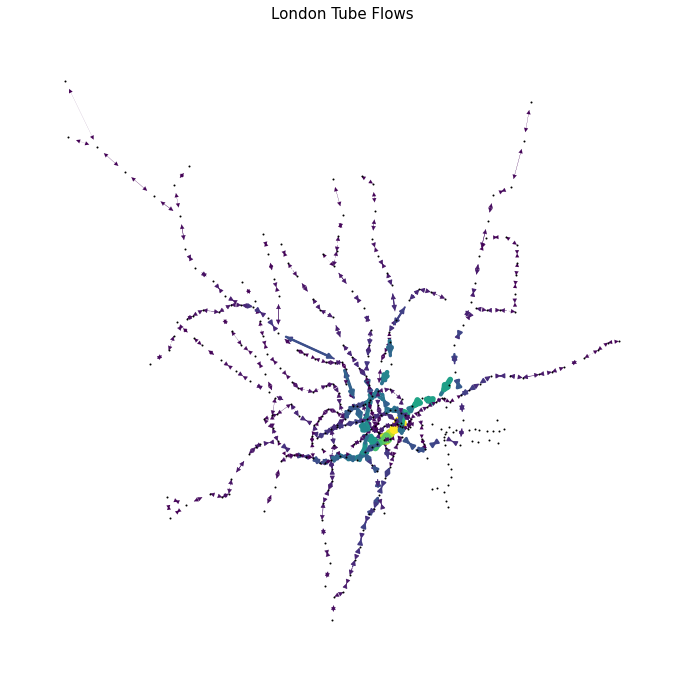

In [9]:
#Create the new graph from the adjancency matrix:
G=nx.from_numpy_matrix(adj_c, create_using=nx.DiGraph) 

#list(g_flows.edges(data=True))[0:1]

nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(G,nod_coord,'station_coord')

nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(G,nod_names,'station')

#list(g_flows.nodes(data=True))[0]

#as edges are saved using the IDs, let us create an edges attribute with the station names:
edges_names={(e1,e2):(G.nodes[e1]['station'],G.nodes[e2]['station']) for e1,e2 in G.edges()}

nx.set_edge_attributes(G,edges_names,'station_names')
#list(G.edges(data=True))[0:1]

## plot !!

# Lets set colour and size of nodes according to the flows_
weights = [w for e1,e2,w in G.edges(data='weight')]

weights_color=[(w/max(weights)) for e1,e2,w in G.edges(data='weight')]
weights_size=[(w/max(weights)*10) for e1,e2,w in G.edges(data='weight')]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in G.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(G, pos,edge_color=weights_color, width=weights_size)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.axis("off")
plt.title("London Tube Flows",fontsize=15)
plt.show()

### plot the after

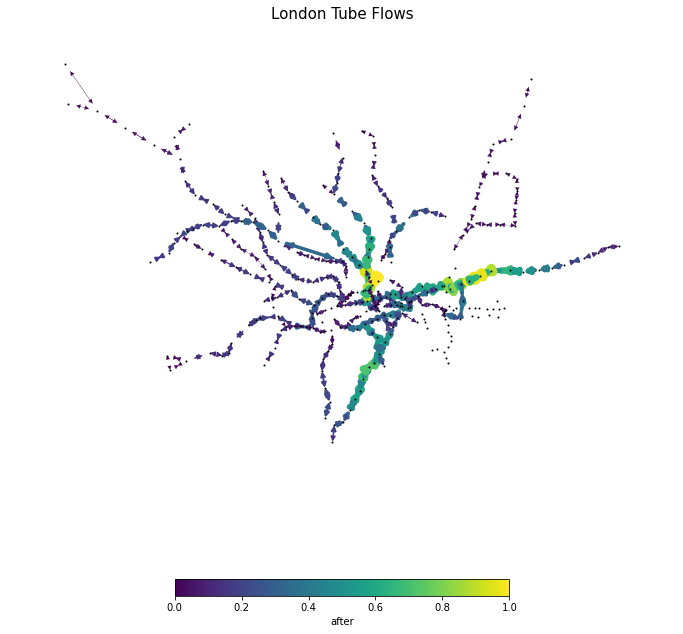

In [37]:
#Create the new graph from the adjancency matrix:
G=nx.from_numpy_matrix(adj_c_after, create_using=nx.DiGraph) 

#list(g_flows.edges(data=True))[0:1]

nod_coord = {(e1):coord for e1,coord in g_shp_un.nodes(data='station_coord')}
nx.set_node_attributes(G,nod_coord,'station_coord')

nod_names = {(e1):name for e1,name in g_shp_un.nodes(data='station')}
nx.set_node_attributes(G,nod_names,'station')

#list(g_flows.nodes(data=True))[0]

#as edges are saved using the IDs, let us create an edges attribute with the station names:
edges_names={(e1,e2):(G.nodes[e1]['station'],G.nodes[e2]['station']) for e1,e2 in G.edges()}

nx.set_edge_attributes(G,edges_names,'station_names')
#list(G.edges(data=True))[0:1]

## plot !!

# Lets set colour and size of nodes according to the flows_
weights = [w for e1,e2,w in G.edges(data='weight')]

weights_color=[(w/max(weights)) for e1,e2,w in G.edges(data='weight')]
weights_size=[(w/max(weights)*10) for e1,e2,w in G.edges(data='weight')]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

pos = {e1: xy for e1,xy in G.nodes(data='station_coord')}

edg=nx.draw_networkx_edges(G, pos,edge_color=weights_color, width=weights_size)

#edg=nx.draw_networkx_edges(G, pos, width=weights_size)


nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.axis("off")
plt.colorbar(nod,label="after",orientation="horizontal", shrink=0.5)
plt.title("London Tube Flows",fontsize=15)
plt.show()

#### betweenness 

In [23]:
v_weights={(e1, e2):round(1./weight,7) for e1, e2, weight in g_flows.edges(data='weight')}
nx.set_edge_attributes(g_flows, v_weights, 'v_weights')

#now let us compute betweenness centrality for directed commuting flows:
bet_london_w=nx.betweenness_centrality(g_flows, weight='v_weights', normalized=False)
# We can add these values to the nodes attributes:
nx.set_node_attributes(g_flows,bet_london_w,'betweenness_flows')

list(g_flows.nodes(data = True))[0:1]

[(0,
  {'station_coord': (-0.1571, 51.5226),
   'station': 'Baker Street',
   'betweenness_flows': 29011.0})]

## betweeness centrality -- undirected and weighted distance network

### node removal ( remove 10 nodes in one go --- unsequential )

In [14]:
g_shp_un_unsequential=g_shp_un.copy()

#len(list(g_shp_un_unsequential.nodes(data=True)))
#g_shp_un_unsequential.nodes[258]['station']

bet_london_w=nx.betweenness_centrality(g_shp_un_unsequential, weight='distance', normalized=False)

nx.set_node_attributes(g_shp_un_unsequential,bet_london_w,'betweenness_un')

#get a list of nodes with higeher betweeness centrality:
dict_bet_un=dict(g_shp_un_unsequential.nodes(data=True))

from collections import OrderedDict
listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True))
#list(listbet_un.items())[:13]

from collections import OrderedDict

i=0
while i<10:
    dict_bet_un=dict(g_shp_un_unsequential.nodes(data=True))
    listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True))
    #list(listbet_un.items())[:10]
    g_shp_un_unsequential.remove_node(list(listbet_un.items())[0][0])
    i+=1

#list(listbet_un.items())[:3]
len(list(g_shp_un_unsequential.nodes(data=True)))

296

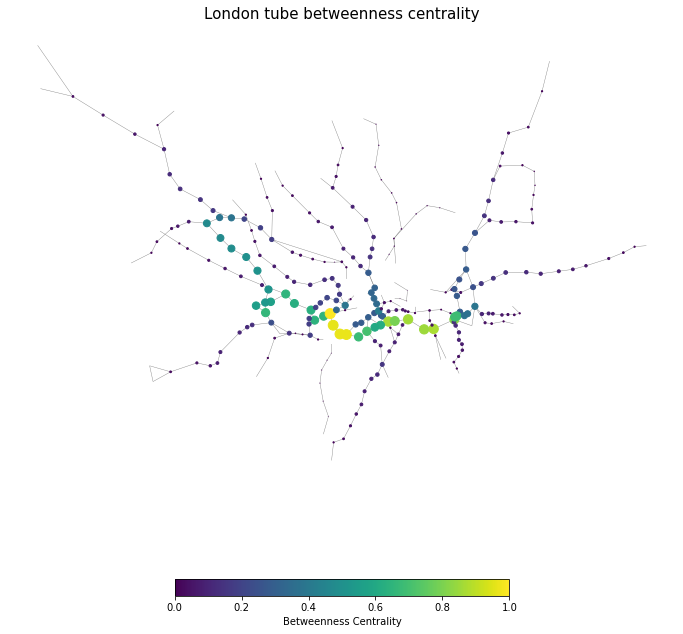

In [10]:
bet_london_w=nx.betweenness_centrality(g_shp_un_unsequential, weight='distance', normalized=False)
# We can add these values as node attributes:
nx.set_node_attributes(g_shp_un_unsequential,bet_london_w,'betweenness_un')


# Lets set colour and size of nodes according to betweenness values
betweenness_w_values=[(i[1]['betweenness_un']) for i in g_shp_un_unsequential.nodes(data=True)]

bet_w_color=[(i[1]['betweenness_un']/max(betweenness_w_values)) for i in g_shp_un_unsequential.nodes(data=True)]
bet_w_size=[(i[1]['betweenness_un']/max(betweenness_w_values)*100) for i in g_shp_un_unsequential.nodes(data=True)]


# Plot graph
#pos_shp = {xy: xy for xy in g_shp.nodes()}
pos={e1: xy for e1,xy in g_shp_un_unsequential.nodes(data='station_coord')}

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(g_shp_un_unsequential, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(g_shp_un_unsequential,
        pos = pos,
        node_color= bet_w_color,
        node_size= bet_w_size)

plt.colorbar(nod,label="Betweenness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube betweenness centrality",fontsize=15)
plt.show()

### evaluate the impact of nodes removel

1. clustering coefficients 

2. degree distribution

### 3. largest component R-index

In [72]:
# let's also plot some basic information about the network
G=g_shp_un

print(nx.info(G))
print(f'Number of connected components:{nx.number_connected_components(G)}')
print(f'Highest degree node: {sorted(G.degree(), key=lambda pair: pair[1])[-1]}')

Name: 
Type: Graph
Number of nodes: 306
Number of edges: 353
Average degree:   2.3072
Number of connected components:1
Highest degree node: (88, 7)


In [73]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
Gsub = G.subgraph(Gcc[0])

# calculate the percentage of nodes present in the largest connected components
percent_lcc = (len(Gsub.nodes)/len(G.nodes)) * 100

lb = '\n \t'
print(f'Largest Connected Compenent:{percent_lcc:.2f}%')#??
print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{hero[0]}: {hero[1]}' for hero in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

#check this out
print(type(sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)))

Largest Connected Compenent:100.00%
Name: 
Type: Graph
Number of nodes: 306
Number of edges: 353
Average degree:   2.3072
Number of connected components:1
Highest degree nodes: 
 	0: 7
 	88: 7
 	10: 6
 	24: 6
 	25: 6
<class 'list'>


### R-index ( Variant )

/Users/zhangjiawei/opt/anaconda3/envs/urbsim/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


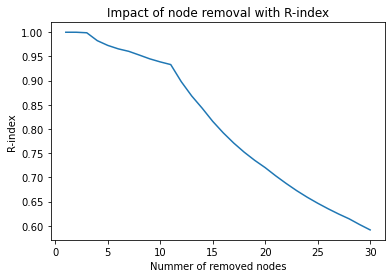

In [142]:
g_shp_un_unsequential=g_shp_un.copy()

bet_london_w=nx.betweenness_centrality(g_shp_un_unsequential, weight='distance', normalized=False)

nx.set_node_attributes(g_shp_un_unsequential,bet_london_w,'betweenness_un')

from collections import OrderedDict

i=0
G=g_shp_un_unsequential
percent_lcc=[]

while i<31:
    dict_bet_un=dict(g_shp_un_unsequential.nodes(data=True))
    listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True))
    #print(list(listbet_un.items())[0])
    g_shp_un_unsequential.remove_node(list(listbet_un.items())[0][0])
    Gcc = sorted(nx.connected_components(g_shp_un_unsequential), key=len, reverse=True)
    Gsub = g_shp_un_unsequential.subgraph(Gcc[0])
    percent = (len(Gsub.nodes)/len(g_shp_un_unsequential.nodes)) 
    percent_lcc.append(percent)
    i+=1

#list(listbet_un.items())[:3]
#len(list(g_shp_un_unsequential.nodes(data=True)))



#R_index=pd.dataframe(percent_lcc)
#R_index['R_in']=R_index.sQ
R_index = pd.DataFrame(percent_lcc,columns=['sQ'])
R_in=[]
for i in R_index.index:
    j=np.sum(R_index.sQ[0:i])
    k= j/i
    R_in.append(k)
    
    
R_index['R_in'] = np.array(R_in)
R_index.dropna(subset=['R_in'],inplace=True)

import matplotlib.pyplot as plt

plt.plot(R_index.index,R_index.R_in)
plt.title('Impact of non-seuqential node removal with R-index')
plt.xlabel('Nummer of removed nodes')
plt.ylabel('R-index')
plt.show()

### 4.Maximum Connectivity Coefficient

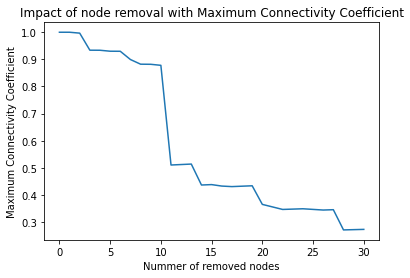

In [33]:
from collections import OrderedDict

# let's also plot some basic information about the network
g_shp_un_unsequential=g_shp_un.copy()

G=g_shp_un_unsequential

bet_london_w=nx.betweenness_centrality(g_shp_un_unsequential, weight='distance', normalized=False)

nx.set_node_attributes(g_shp_un_unsequential,bet_london_w,'betweenness_un')

i=0
percent_lcc=[]

while i<31:
    dict_bet_un=dict(g_shp_un_unsequential.nodes(data=True))
    listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True))
    #print(list(listbet_un.items())[0])
    g_shp_un_unsequential.remove_node(list(listbet_un.items())[0][0])
    Gcc = sorted(nx.connected_components(g_shp_un_unsequential), key=len, reverse=True)
    Gsub = g_shp_un_unsequential.subgraph(Gcc[0])
    percent = (len(Gsub.nodes)/len(g_shp_un_unsequential.nodes)) 
    percent_lcc.append(percent)
    i+=1

#list(listbet_un.items())[:3]
#len(list(g_shp_un_unsequential.nodes(data=True)))

Connectivity_coeff = pd.DataFrame(percent_lcc,columns=['conn_coeff'])
    
#Connectivity_coeff['conn_coeff'] = np.array(conn_coeff)
Connectivity_coeff.dropna(subset=['conn_coeff'],inplace=True)

import matplotlib.pyplot as plt

plt.plot(Connectivity_coeff.index,Connectivity_coeff.conn_coeff)
plt.title('Impact of non-sequential node removal with Maximum Connectivity Coefficient')
plt.xlabel('Nummer of removed nodes')
plt.ylabel('Maximum Connectivity Coefficient')
plt.show()

### 5.Efficiency 

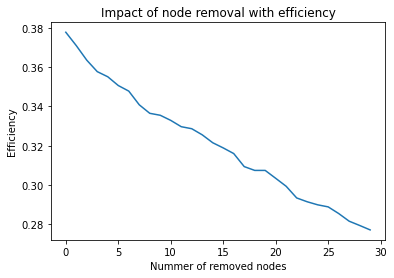

In [124]:
g_shp_un_unsequential=g_shp_un.copy()

G=g_shp_un_unsequential

bet_london_w=nx.betweenness_centrality(G, weight='distance', normalized=False)

nx.set_node_attributes(G,bet_london_w,'betweenness_un')

from collections import OrderedDict

i=0

#dij=[]
efficiency=[]

while i<30:
    dict_bet_un=dict(G.nodes(data=True))
    listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True))
    #print(list(listbet_un.items())[0])
    G.remove_node(list(listbet_un.items())[0][0])
    N=len(G.nodes)
    dij=[]
    for o,d,w in G.edges(data='distance'):
        shortest_distance = nx.dijkstra_path_length(G,o,d,weight='distance')  
        #inver_distance=1/shortest_distance
        dij.append(1/shortest_distance)   
        eff=sum(dij)*(1/N*(N-1))
    efficiency.append(eff)
    i+=1

#list(listbet_un.items())[:3]
#len(list(g_shp_un_unsequential.nodes(data=True)))
#len(efficiency)

effi = pd.DataFrame(efficiency,columns=['efficiency'])
    
#Connectivity_coeff['conn_coeff'] = np.array(conn_coeff)
effi.dropna(subset=['efficiency'],inplace=True)

import matplotlib.pyplot as plt

plt.plot(effi.index,effi.efficiency)
plt.title('Impact of non-sequential node removal with efficiency')
plt.xlabel('Nummer of removed nodes')
plt.ylabel('Efficiency')
plt.show()

In [119]:
'''g_shp_un_unsequential=g_shp_un.copy()
G=g_shp_un

N=len(G.nodes)
dij=[]
efficiency=[]

for i,j,d in G.edges(data='distance'):
    shortest_distance = nx.dijkstra_path_length(G,i,j,weight='distance')  
    inver_distance=1/path
    dij.append(inver_distance)   
    eff=sum(dij)*(1/N*(N-1))
efficiency.append(eff)

efficiency'''

353

### betweeness node removal (recomputing every time remove the node -- sequential)

### R-index

/Users/zhangjiawei/opt/anaconda3/envs/urbsim/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


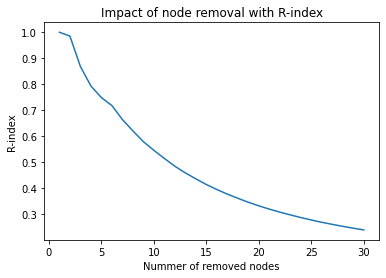

In [69]:
g_shp_un_sequential=g_shp_un.copy()

from collections import OrderedDict


i=0
G=g_shp_un_sequential
percent_lcc=[]

while i<31:
    bet_london_w=nx.betweenness_centrality(g_shp_un_sequential, weight='distance', normalized=False)

    nx.set_node_attributes(g_shp_un_sequential,bet_london_w,'betweenness_un')

    dict_bet_un=dict(g_shp_un_sequential.nodes(data=True))
    listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True))
    #print(list(listbet_un.items())[0])
    g_shp_un_sequential.remove_node(list(listbet_un.items())[0][0])
    Gcc = sorted(nx.connected_components(g_shp_un_sequential), key=len, reverse=True)
    Gsub = g_shp_un_sequential.subgraph(Gcc[0])
    percent = (len(Gsub.nodes)/len(g_shp_un_sequential.nodes)) 
    percent_lcc.append(percent)
    i+=1

#list(listbet_un.items())[:15]
#len(list(g_shp_un_unsequential.nodes(data=True)))

#R_index=pd.dataframe(percent_lcc)
#R_index['R_in']=R_index.sQ
R_index_se = pd.DataFrame(percent_lcc,columns=['sQ'])
R_in=[]
for i in R_index_se.index:
    j=np.sum(R_index_se.sQ[0:i])
    k= j/i
    R_in.append(k)
    
    
R_index_se['R_in'] = np.array(R_in)
R_index_se.dropna(subset=['R_in'],inplace=True)

import matplotlib.pyplot as plt

plt.plot(R_index_se.index,R_index_se.R_in)
plt.title('Impact of node removal with R-index')
plt.xlabel('Nummer of removed nodes')
plt.ylabel('R-index')
plt.show()

### Maximum Connectivity Coefficient

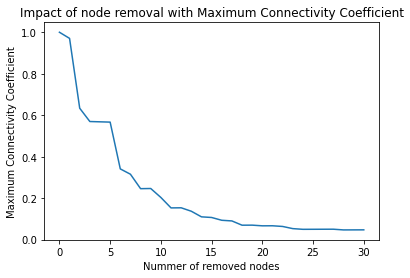

In [70]:
g_shp_un_sequential=g_shp_un.copy()

from collections import OrderedDict


i=0
G=g_shp_un_sequential
percent_lcc=[]

while i<31:
    bet_london_w=nx.betweenness_centrality(g_shp_un_sequential, weight='distance', normalized=False)

    nx.set_node_attributes(g_shp_un_sequential,bet_london_w,'betweenness_un')

    dict_bet_un=dict(g_shp_un_sequential.nodes(data=True))
    listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True))
    #print(list(listbet_un.items())[0])
    g_shp_un_sequential.remove_node(list(listbet_un.items())[0][0])
    Gcc = sorted(nx.connected_components(g_shp_un_sequential), key=len, reverse=True)
    Gsub = g_shp_un_sequential.subgraph(Gcc[0])
    percent = (len(Gsub.nodes)/len(g_shp_un_sequential.nodes)) 
    percent_lcc.append(percent)
    i+=1

#list(listbet_un.items())[:15]
#len(list(g_shp_un_unsequential.nodes(data=True)))

Connectivity_coeff = pd.DataFrame(percent_lcc,columns=['conn_coeff'])

#Connectivity_coeff['conn_coeff'] = np.array(conn_coeff)
Connectivity_coeff.dropna(subset=['conn_coeff'],inplace=True)

import matplotlib.pyplot as plt

plt.plot(Connectivity_coeff.index,Connectivity_coeff.conn_coeff)
plt.title('Impact of node removal with Maximum Connectivity Coefficient')
plt.xlabel('Nummer of removed nodes')
plt.ylabel('Maximum Connectivity Coefficient')
plt.show()

### 5. Efficiency 

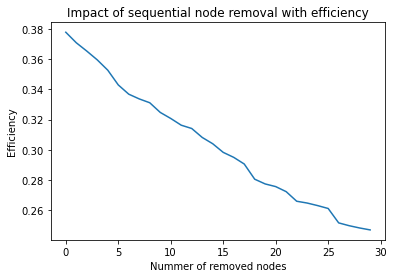

In [74]:
g_shp_un_sequential=g_shp_un.copy()

G=g_shp_un_sequential

from collections import OrderedDict

i=0

#dij=[]
efficiency=[]

while i<30:
    bet_london_w=nx.betweenness_centrality(G, weight='distance', normalized=False)
    nx.set_node_attributes(G,bet_london_w,'betweenness_un')
    dict_bet_un=dict(G.nodes(data=True))
    listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['betweenness_un'],reverse=True))
    #print(list(listbet_un.items())[0])
    G.remove_node(list(listbet_un.items())[0][0])
    N=len(G.nodes)
    dij=[]
    for o,d,w in G.edges(data='distance'):
        shortest_distance = nx.dijkstra_path_length(G,o,d,weight='distance')  
        #inver_distance=1/shortest_distance
        dij.append(1/shortest_distance)   
        eff=sum(dij)*(1/N*(N-1))
    efficiency.append(eff)
    i+=1

#list(listbet_un.items())[:3]
#len(list(g_shp_un_sequential.nodes(data=True)))
#len(efficiency)

effi = pd.DataFrame(efficiency,columns=['efficiency'])
    
#Connectivity_coeff['conn_coeff'] = np.array(conn_coeff)
effi.dropna(subset=['efficiency'],inplace=True)

import matplotlib.pyplot as plt

plt.plot(effi.index,effi.efficiency)
plt.title('Impact of sequential node removal with efficiency')
plt.xlabel('Nummer of removed nodes')
plt.ylabel('Efficiency')
plt.show()

## degree centrality

### remove 10 nodes in one go -- non-sequential 

In [43]:
g_shp_un_unsequential=g_shp_un.copy()

degree_london_w=nx.degree(g_shp_un_unsequential)

nx.set_node_attributes(g_shp_un_unsequential,dict(degree_london_w),'degree_un')

In [44]:
len(list(g_shp_un_unsequential.nodes(data=True)))

306

In [45]:
#get a list of nodes with higeher betweeness centrality:
dict_bet_un=dict(g_shp_un_unsequential.nodes(data=True))

from collections import OrderedDict
listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['degree_un'],reverse=True))
list(listbet_un.items())[:13]

[(0,
  {'station': 'Baker Street',
   'station_coord': (-0.1571, 51.5226),
   'degree_un': 7}),
 (88,
  {'station': "King's Cross St. Pancras",
   'station_coord': (-0.1238, 51.5308),
   'degree_un': 7}),
 (10,
  {'station': 'Waterloo',
   'station_coord': (-0.1143, 51.5036),
   'degree_un': 6}),
 (24,
  {'station': 'Oxford Circus',
   'station_coord': (-0.1415, 51.515),
   'degree_un': 6}),
 (25,
  {'station': 'Bank', 'station_coord': (-0.0886, 51.5133), 'degree_un': 6}),
 (116,
  {'station': "Earl's Court",
   'station_coord': (-0.1973, 51.492),
   'degree_un': 6}),
 (155,
  {'station': 'Green Park',
   'station_coord': (-0.1428, 51.5067),
   'degree_un': 6}),
 (7,
  {'station': 'Paddington',
   'station_coord': (-0.1755, 51.5154),
   'degree_un': 5}),
 (26,
  {'station': 'Liverpool Street',
   'station_coord': (-0.0823, 51.5178),
   'degree_un': 5}),
 (112,
  {'station': 'Turnham Green',
   'station_coord': (-0.2547, 51.4951),
   'degree_un': 5}),
 (143,
  {'station': 'Shadwell', 's

In [46]:
for i in range(0,10):
    #l=list(listbet_un.items())[i][0]
    g_shp_un_unsequential.remove_node(list(listbet_un.items())[i][0])
    #i+=1

dict_bet_un=dict(g_shp_un_unsequential.nodes(data=True))
listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['degree_un'],reverse=True))
list(listbet_un.items())[:3]

[(143,
  {'station': 'Shadwell', 'station_coord': (-0.056, 51.5117), 'degree_un': 5}),
 (158,
  {'station': 'Canning Town',
   'station_coord': (0.0082, 51.5147),
   'degree_un': 5}),
 (4,
  {'station': 'Embankment',
   'station_coord': (-0.1223, 51.5074),
   'degree_un': 4})]

In [47]:
len(list(g_shp_un_unsequential.nodes(data=True)))

296

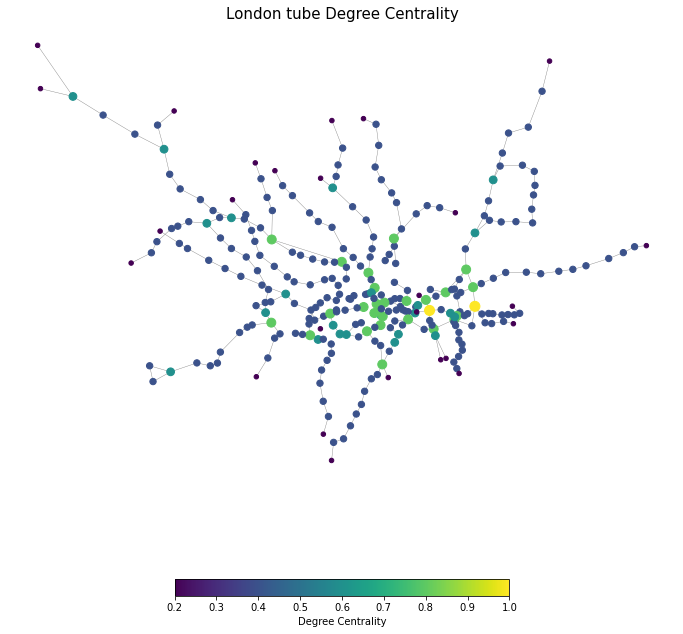

In [48]:
# Lets set colour and size of nodes according to betweenness values
degree_w_values=[(i[1]['degree_un']) for i in g_shp_un_unsequential.nodes(data=True)]

deg_w_color=[(i[1]['degree_un']/max(degree_w_values)) for i in g_shp_un_unsequential.nodes(data=True)]
deg_w_size=[(i[1]['degree_un']/max(degree_w_values)*100) for i in g_shp_un_unsequential.nodes(data=True)]


# Plot graph
#pos_shp = {xy: xy for xy in g_shp.nodes()}
pos={e1: xy for e1,xy in g_shp_un_unsequential.nodes(data='station_coord')}

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(g_shp_un_unsequential, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(g_shp_un_unsequential,
        pos = pos,
        node_color= deg_w_color,
        node_size= deg_w_size)

plt.colorbar(nod,label="Degree Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube Degree Centrality",fontsize=15)
plt.show()

## closeness centrality

A node that is very close to most nodes, and has hence low mean shortest path distance, will be more influential than a node which is far away. 

### remove 10 nodes in one go--- non-sequential 

In [49]:
g_shp_un_unsequential=g_shp_un.copy()

v_weights={(e1, e2):round(1./weight,7) for e1, e2, weight in g_shp_un_unsequential.edges(data='distance')}

# Let us add the inverted weight as an attribute to the edges in the graph
nx.set_edge_attributes(g_shp_un_unsequential, v_weights, 'v_weights')

# Print edge list with attributes
list(g_shp_un_unsequential.edges(data = True))[0:2]

[(0,
  1,
  {'toid_seq': '1',
   'station_1': 11,
   'station_1_': 'Baker Street',
   'station_2': 163,
   'station_2_': 'Marylebone',
   'distance': 416.586050414,
   'ShpName': 'underground',
   'v_weights': 0.0024005}),
 (0,
  2,
  {'toid_seq': '2',
   'station_1': 11,
   'station_1_': 'Baker Street',
   'station_2': 212,
   'station_2_': "Regent's Park",
   'distance': 734.173636158,
   'ShpName': 'underground',
   'v_weights': 0.0013621})]

In [50]:
closeness_london_w=nx.closeness_centrality(g_shp_un_unsequential, distance='v_weights')

# Let us add the closeness centrality as attribute to the nodes in the graph
nx.set_node_attributes(g_shp_un_unsequential,closeness_london_w,'closeness')

list(g_shp_un_unsequential.nodes(data=True))[0]

(0,
 {'station': 'Baker Street',
  'station_coord': (-0.1571, 51.5226),
  'closeness': 115.68045099749551})

In [51]:
#get a list of nodes with higeher betweeness centrality:
dict_bet_un=dict(g_shp_un_unsequential.nodes(data=True))

from collections import OrderedDict
listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['closeness'],reverse=True))
list(listbet_un.items())[:13]

[(155,
  {'station': 'Green Park',
   'station_coord': (-0.1428, 51.5067),
   'closeness': 123.7033857251646}),
 (86,
  {'station': 'Westminster',
   'station_coord': (-0.1254, 51.501),
   'closeness': 121.26183555272972}),
 (10,
  {'station': 'Waterloo',
   'station_coord': (-0.1143, 51.5036),
   'closeness': 119.73179606605291}),
 (25,
  {'station': 'Bank',
   'station_coord': (-0.0886, 51.5133),
   'closeness': 119.14297528134831}),
 (33,
  {'station': 'Bond Street',
   'station_coord': (-0.1494, 51.5142),
   'closeness': 119.03909302358709}),
 (93,
  {'station': 'Victoria',
   'station_coord': (-0.1447, 51.4965),
   'closeness': 116.67984256254948}),
 (24,
  {'station': 'Oxford Circus',
   'station_coord': (-0.1415, 51.515),
   'closeness': 116.1440274285735}),
 (0,
  {'station': 'Baker Street',
   'station_coord': (-0.1571, 51.5226),
   'closeness': 115.68045099749551}),
 (143,
  {'station': 'Shadwell',
   'station_coord': (-0.056, 51.5117),
   'closeness': 113.90293639902774}),
 

In [52]:
for i in range(0,10):
    #l=list(listbet_un.items())[i][0]
    g_shp_un_unsequential.remove_node(list(listbet_un.items())[i][0])
    #i+=1

dict_bet_un=dict(g_shp_un_unsequential.nodes(data=True))
listbet_un=OrderedDict(sorted(dict_bet_un.items(), key=lambda x: x[1]['closeness'],reverse=True))
list(listbet_un.items())[:3]

[(165,
  {'station': 'Finchley Road',
   'station_coord': (-0.1803, 51.5472),
   'closeness': 112.92798874659628}),
 (170,
  {'station': 'Wembley Park',
   'station_coord': (-0.2795, 51.5635),
   'closeness': 111.75365595673368}),
 (4,
  {'station': 'Embankment',
   'station_coord': (-0.1223, 51.5074),
   'closeness': 110.48990026312174})]

In [42]:
len(list(g_shp_un_unsequential.nodes(data=True)))

296

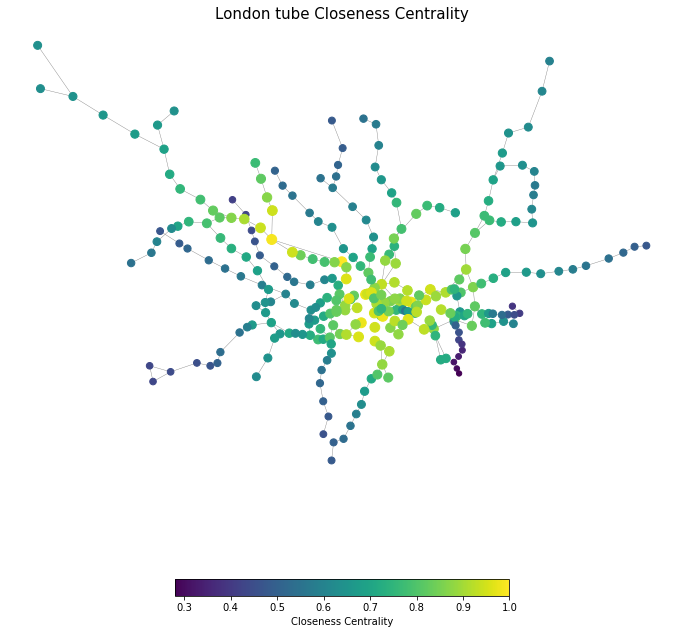

In [53]:
# Lets set colour and size of nodes according to betweenness values
degree_w_values=[(i[1]['closeness']) for i in g_shp_un_unsequential.nodes(data=True)]

deg_w_color=[(i[1]['closeness']/max(degree_w_values)) for i in g_shp_un_unsequential.nodes(data=True)]
deg_w_size=[(i[1]['closeness']/max(degree_w_values)*100) for i in g_shp_un_unsequential.nodes(data=True)]


# Plot graph
#pos_shp = {xy: xy for xy in g_shp.nodes()}
pos={e1: xy for e1,xy in g_shp_un_unsequential.nodes(data='station_coord')}

fig, ax = plt.subplots(figsize=(12,12))


nx.draw_networkx_edges(g_shp_un_unsequential, pos,edge_color='gray', 
        width=0.4)
nod=nx.draw_networkx_nodes(g_shp_un_unsequential,
        pos = pos,
        node_color= deg_w_color,
        node_size= deg_w_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London tube Closeness Centrality",fontsize=15)
plt.show()